In [2]:
import sys
sys.path.append("estimators")
sys.path.append("simulations")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
from generation import *
from estimators_RKHS import *

In [ ]:
def compute_results(n_target):
    gamma_seq = np.arange(0.00005, 0.22, 0.005)
    gen_params = {
        'p' :5,
        'beta': 1, 
        'n_plus': 150,
        'n_minus': 150,
        'n_target': n_target,
        'pi_target': 0.75
    }
    N = 100

    df_results_emp = pd.DataFrame(np.zeros((N*len(gamma_seq), 7)), 
                          columns=['pi_ipr', 'pi_nrm','var_n', 'var', 'seed', 'gamma', 'var_rbf'])
    iter = 0

    df_results = pd.DataFrame(np.zeros((N, 2)), 
                          columns=['gamma_numerical', 'gamma_grid'])
    
    for i in tqdm(range(N)):
        p_source_plus, p_source_minus, p_target = generate_sample_Nstd_Nstd_CC(**gen_params, seed=i)
        for gamma in gamma_seq:
            
            mod = estimator_RHKS(p_target, p_source_plus, p_source_minus, kernel_params={'gamma': gamma})
            mod.compute_basic_simulations()

            df_results_emp.loc[iter, 'pi_ipr'] = mod.pi_ipr
            df_results_emp.loc[iter, 'pi_nrm'] =  mod.pi_nrm
            df_results_emp.loc[iter, 'var_n'] = mod.var_plug_in_n
            df_results_emp.loc[iter, 'var'] = mod.var_plug_in
            df_results_emp.loc[iter, 'seed'] = i
            df_results_emp.loc[iter, 'gamma'] =  gamma
            df_results_emp.loc[iter, 'var_rbf'] = generate_sample_Nstd_Nstd_CC_rbf(**gen_params, gamma=gamma)[0]*mod.r_n


            iter = iter + 1
        mod = estimator_RHKS_rbf_gamma(p_target, p_source_plus, p_source_minus, 'numerical')
        mod.compute_basic_simulations()
        df_results.loc[i, 'gamma_numerical'] = mod.gamma_opt
        
        mod = estimator_RHKS_rbf_gamma(p_target, p_source_plus, p_source_minus, 'grid')
        mod.compute_basic_simulations()
        df_results.loc[i, 'gamma_grid'] = mod.gamma_opt

    df_results_emp['MSE'] = (df_results_emp['pi_ipr'] - gen_params['pi_target'])**2

    df1 = df_results_emp[['gamma', 'MSE']].groupby('gamma').aggregate(np.mean).reset_index()
    # df1['RMSE_div20'] = np.sqrt(df1['MSE'])/20
    df2 = df_results_emp[['gamma', 'pi_ipr']].groupby('gamma').aggregate(np.var, ddof=0).reset_index()
    df2.rename(columns={df2.columns[1]: "var_emp"}, inplace=True)
    df3 = df_results_emp[['gamma', 'var_n']].groupby('gamma').aggregate(np.mean).reset_index()
    df3.rename(columns={df3.columns[1]: "est_var_as"}, inplace=True)
    df4 = df_results_emp[['gamma', 'var_rbf']].groupby('gamma').aggregate(np.mean).reset_index()
    df = df1.merge(df2, on='gamma')
    df = df.merge(df3, on='gamma')
    df = df.merge(df4, on='gamma')

    return df_results_emp, df_results, df

In [6]:
df_results_emp_list = []
df_results_list = []
df_list = []
for n_target in [100,200,300,400,500]:
    df_results_emp, df_results, df = compute_results(n_target)
    df_results_emp_list.append(df_results_emp)
    df_results_list.append(df_results)
    df_list.append(df)

100%|██████████| 100/100 [00:29<00:00,  3.41it/s]
/tmp/ipykernel_1059833/2276536972.py:47: FutureWarning: The provided callable <function mean at 0x7e72581cc2c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df1 = df_results_emp[['gamma', 'MSE']].groupby('gamma').aggregate(np.mean).reset_index()
/tmp/ipykernel_1059833/2276536972.py:49: FutureWarning: The provided callable <function var at 0x7e72581cc540> is currently using DataFrameGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  df2 = df_results_emp[['gamma', 'pi_ipr']].groupby('gamma').aggregate(np.var).reset_index()
/tmp/ipykernel_1059833/2276536972.py:51: FutureWarning: The provided callable <function mean at 0x7e72581cc2c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provid

/home/gosia/miniconda3/envs/rhks/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:4266: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/gosia/miniconda3/envs/rhks/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:4266: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/gosia/miniconda3/envs/rhks/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:4266: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the

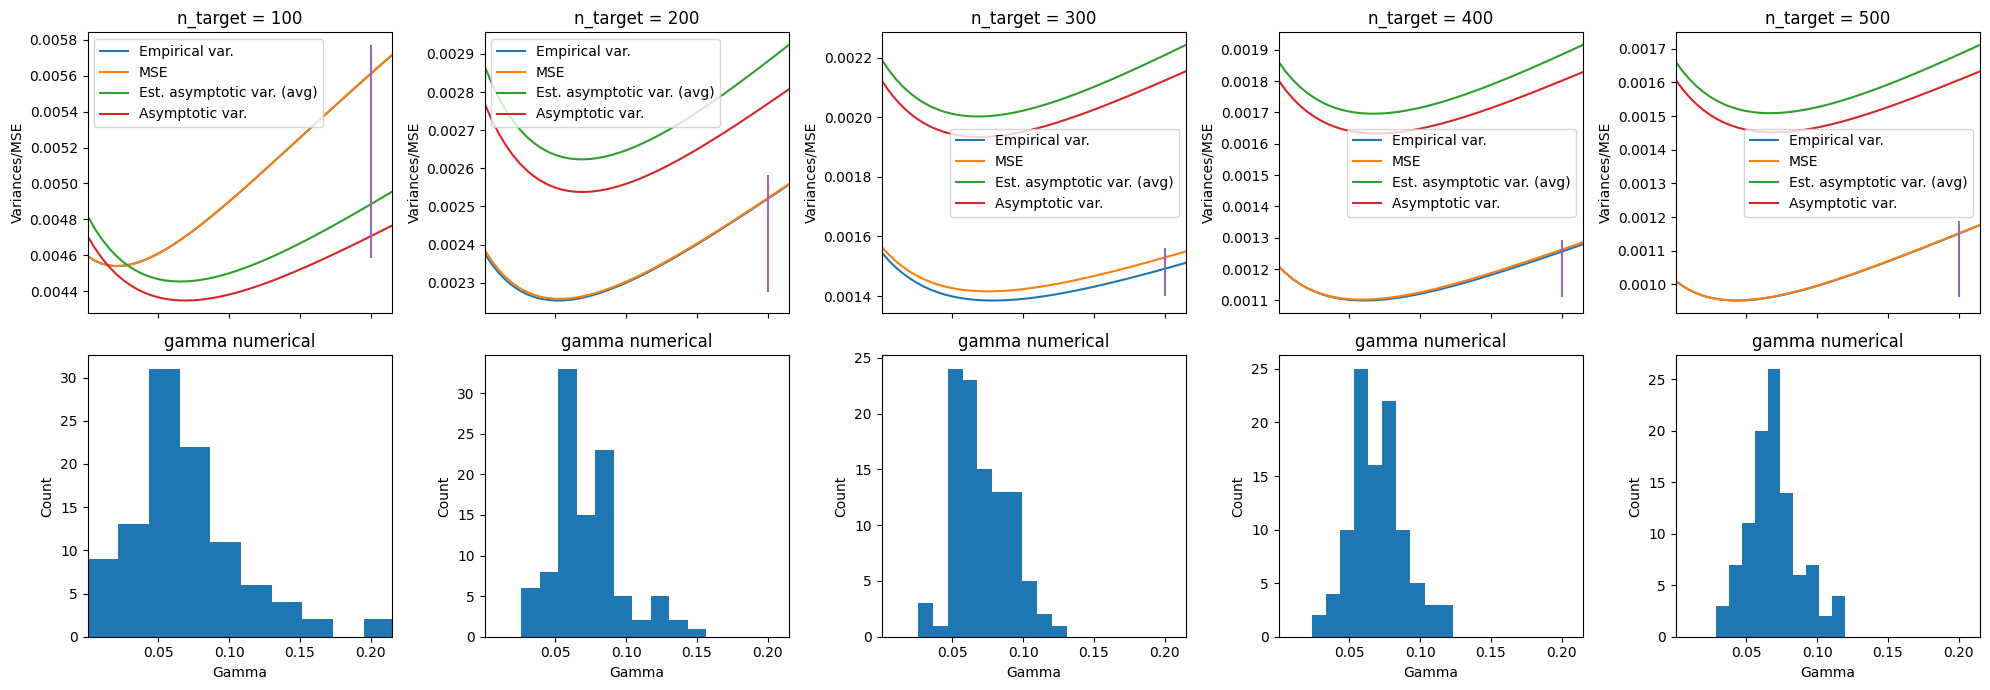

In [14]:
fig, axes = plt.subplots(2, 5, sharex=True, figsize=(20, 7))

for i in range(5):
    gamma_seq = np.sort(df_results_emp_list[i]['gamma'].unique().tolist())
    df_results_emp = df_results_emp_list[i]
    df_results = df_results_list[i]
    df = df_list[i]
    n_target = [100,200,300,400,500][i]
    # First plot
    df2 = df_results_emp[['gamma', 'pi_ipr']].groupby('gamma').aggregate(np.var, ddof=0).reset_index()
    df2.rename(columns={df2.columns[1]: "var_emp"}, inplace=True)
    axes[0, i].plot(df2['gamma'], df2['var_emp'], label='Empirical var.')
    # axes[0, i].plot(df['gamma'], df.loc[0,'var_emp']*df['MSE']/df.loc[0,'MSE'], label='MSE (scaled)')
    axes[0, i].plot(df['gamma'], df['MSE'], label='MSE')
    axes[0, i].plot(df['gamma'], df['est_var_as'], label='Est. asymptotic var. (avg)')
    axes[0, i].plot(df['gamma'], df['var_rbf'], label='Asymptotic var.')
    axes[0, i].vlines(x=0.2, ymin=np.min(df['var_emp']), ymax=np.max(df['var_emp']), color='C4')
    axes[0, i].legend()
    axes[0, i].set_ylabel("Variances/MSE")
    axes[0, i].set_title('n_target = '+str(n_target))

    # Second plot (histogram)
    axes[1, i].hist(df_results['gamma_numerical'])
    axes[1,i].set_xlim(gamma_seq[0], gamma_seq[-1])
    axes[1,i].set_xlabel("Gamma")
    axes[1,i].set_ylabel("Count")
    axes[1,i].set_title('gamma numerical')

plt.tight_layout()
plt.show()

In [ ]:
df2 = df_results_emp_[['gamma', 'pi_ipr']].groupby('gamma').aggregate(np.var, ddof=0).reset_index()
df2.rename(columns={df2.columns[1]: "var_emp"}, inplace=True)

/home/gosia/miniconda3/envs/rhks/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:4266: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [11]:
df2

,gamma,var_emp
0,0.00005,0.004596
1,0.00505,0.004571
2,0.01005,0.004554
3,0.01505,0.004544
4,0.02005,0.004540
5,0.02505,0.004542
6,0.03005,0.004548
7,0.03505,0.004559
8,0.04005,0.004573
9,0.04505,0.004590


In [8]:
i=0
df_results_emp = df_results_emp_list[i]
df_results = df_results_list[i]
df = df_list[i]
n_target = [100,200,300,400,500][i]

df1 = df_results_emp[['gamma', 'pi_ipr']].groupby('gamma').aggregate(np.mean).reset_index()
df1['bias'] = (df1['pi_ipr'] - 0.75)**2
df = df.merge(df1, on='gamma')

df

/tmp/ipykernel_1059833/1835072932.py:7: FutureWarning: The provided callable <function mean at 0x7e72581cc2c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df1 = df_results_emp[['gamma', 'pi_ipr']].groupby('gamma').aggregate(np.mean).reset_index()


,gamma,MSE,var_emp,est_var_as,var_rbf,pi_ipr,bias
0,0.00005,0.004596,0.004643,0.004820,0.004708,0.750103,1.069972e-08
1,0.00505,0.004571,0.004617,0.004751,0.004642,0.750037,1.335301e-09
2,0.01005,0.004554,0.004600,0.004691,0.004586,0.749986,1.895121e-10
3,0.01505,0.004544,0.004590,0.004641,0.004538,0.749950,2.512245e-09
4,0.02005,0.004540,0.004586,0.004599,0.004498,0.749925,5.582873e-09
5,0.02505,0.004542,0.004588,0.004564,0.004464,0.749911,7.989702e-09
6,0.03005,0.004548,0.004594,0.004535,0.004435,0.749904,9.149803e-09
7,0.03505,0.004559,0.004605,0.004511,0.004412,0.749905,8.989956e-09
8,0.04005,0.004573,0.004619,0.004493,0.004393,0.749912,7.735864e-09
9,0.04505,0.004590,0.004636,0.004478,0.004378,0.749924,5.774228e-09


In [1]:
fig, axes = plt.subplots(1, 5, figsize=(20, 3))

for i in range(5):
    gamma_seq = np.sort(df_results_emp_list[i]['gamma'].unique().tolist())
    df_results_emp = df_results_emp_list[i]
    df_results = df_results_list[i]
    df = df_list[i]
    n_target = [100,200,300,400,500][i]

    df1 = df_results_emp[['gamma', 'pi_ipr']].groupby('gamma').aggregate(np.mean).reset_index()
    df1['bias'] = (df1['pi_ipr'] - 0.75)**2

    df = df.merge(df1, on='gamma')

    # df_results_emp_list[i]['var_div_bias2'] = df_results_emp_list[i]['var_n']/df_results_emp_list[i]['MSE']
    # df1 = df_results_emp_list[i][['gamma', 'var_div_bias2']].groupby('gamma').aggregate(np.mean).reset_index()
    # First plot
    # axes[i].plot(df['gamma'], df['bias'], label="Bias2")
    axes[i].plot(df['gamma'], df['var_emp'], label="Variance")
    axes[i].plot(df['gamma'], df['MSE'], label="MSE")
    axes[i].legend()
    axes[i].set_xlabel("gamma")
    # axes[0, i].set_title('n_target = '+str(n_target))

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

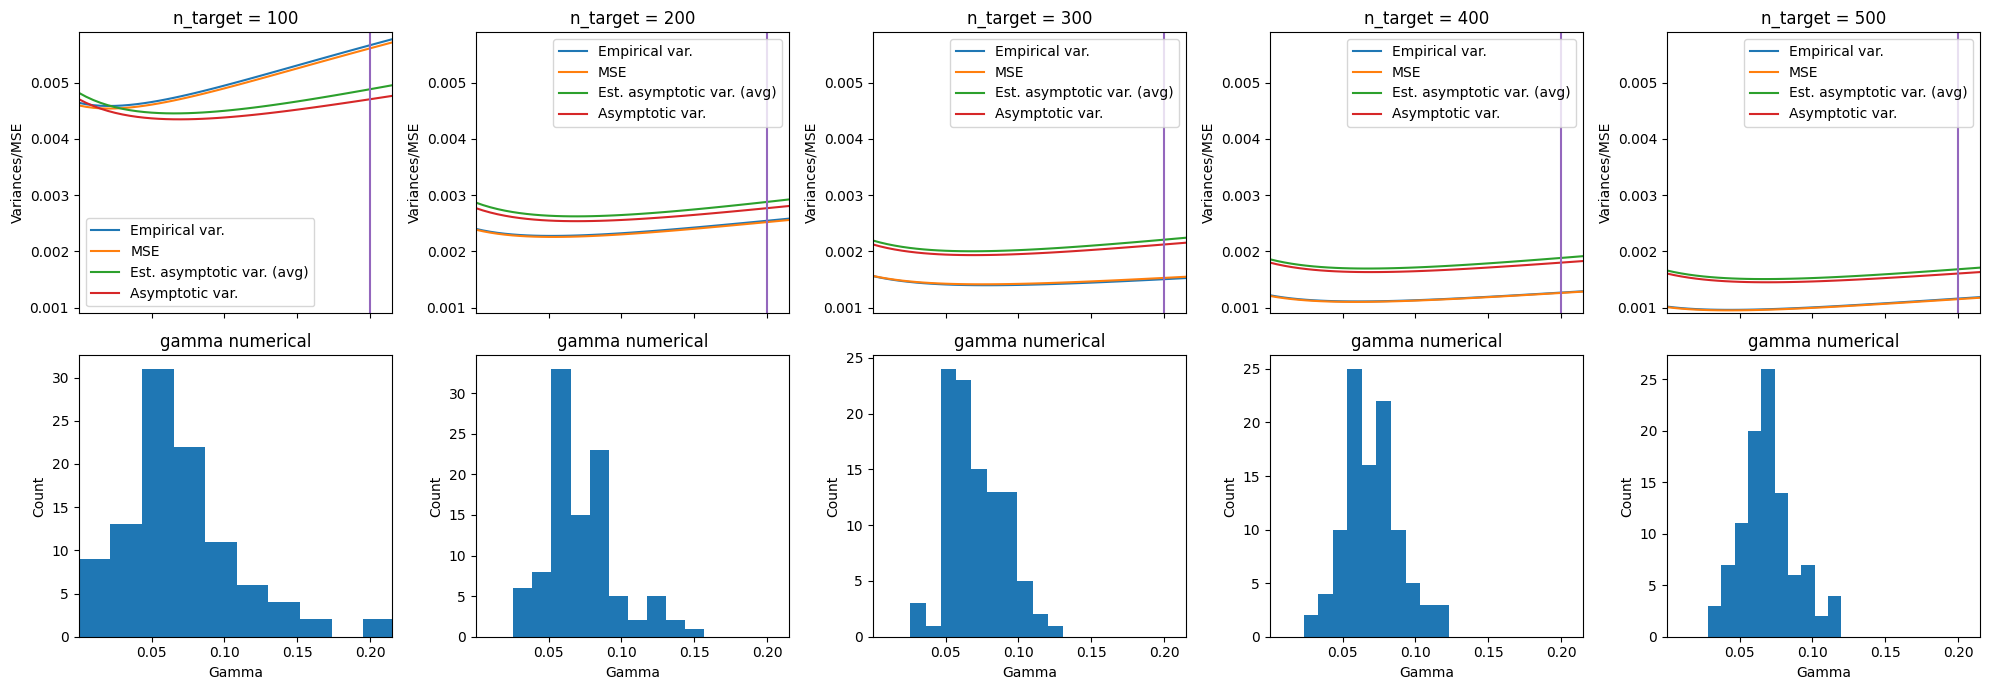

In [369]:
fig, axes = plt.subplots(2, 5, sharex=True, figsize=(20, 7))

for i in range(5):
    gamma_seq = np.sort(df_results_emp_list[i]['gamma'].unique().tolist())
    df_results_emp = df_results_emp_list[i]
    df_results = df_results_list[i]
    df = df_list[i]
    n_target = [100,200,300,400,500][i]
    # First plot
    axes[0, i].plot(df['gamma'], df['var_emp'], label='Empirical var.')
    # axes[0, i].plot(df['gamma'], df.loc[0,'var_emp']*df['MSE']/df.loc[0,'MSE'], label='MSE (scaled)')
    axes[0, i].plot(df['gamma'], df['MSE'], label='MSE')
    axes[0, i].plot(df['gamma'], df['est_var_as'], label='Est. asymptotic var. (avg)')
    axes[0, i].plot(df['gamma'], df['var_rbf'], label='Asymptotic var.')
    axes[0, i].vlines(x=0.2, ymin=0.0009, ymax=0.0059, color='C4')
    axes[0, i].legend()
    axes[0, i].set_ylabel("Variances/MSE")
    axes[0, i].set_title('n_target = '+str(n_target))
    axes[0, i].set_ylim(0.0009, 0.0059)

    # Second plot (histogram)
    axes[1, i].hist(df_results['gamma_numerical'])
    axes[1,i].set_xlim(gamma_seq[0], gamma_seq[-1])
    axes[1,i].set_xlabel("Gamma")
    axes[1,i].set_ylabel("Count")
    axes[1,i].set_title('gamma numerical')

plt.tight_layout()
plt.show()

In [344]:
df1 = df_results_emp_list[0][['gamma', 'var_div_bias2']].groupby('gamma').aggregate(np.mean).reset_index()

/tmp/ipykernel_921517/55206379.py:1: FutureWarning: The provided callable <function mean at 0x7ecaa01253a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df1 = df_results_emp_list[0][['gamma', 'var_div_bias2']].groupby('gamma').aggregate(np.mean).reset_index()


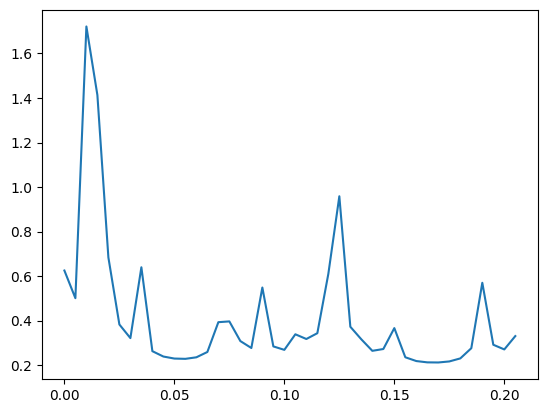

In [345]:
plt.plot(df1['gamma'], df1['var_div_bias2'])

In [342]:
df_results_emp_list[0]['var_div_bias2'] = df_results_emp_list[0]['var_n']/df_results_emp_list[0]['MSE']

<Axes: xlabel='gamma', ylabel='var_div_bias2'>

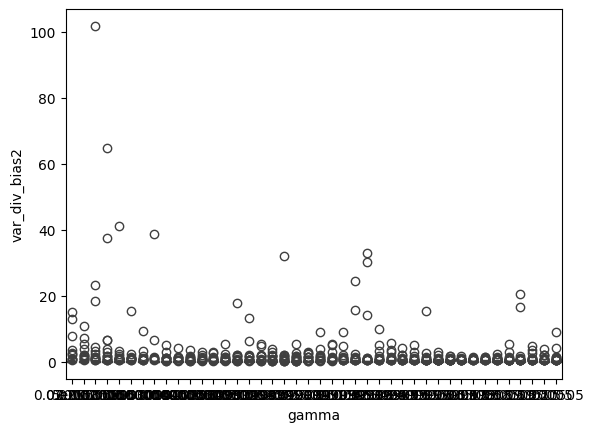

In [343]:
sns.boxplot(df_results_emp_list[0], x='gamma', y='var_div_bias2')

In [297]:
# sns.boxplot(df_results_emp, x='gamma', y='pi_ipr')
# plt.show()

# sns.boxplot(df_results_emp, x='gamma', y='var_n')

# plt.show()
# sns.pointplot(df_results_emp[['gamma', 'MSE']].groupby('gamma').aggregate(np.var).reset_index(),
#              x='gamma', y='MSE')
# plt.show()
# sns.pointplot(df_results_emp[['gamma', 'pi_ipr']].groupby('gamma').aggregate(np.var).reset_index(),
#              x='gamma', y='pi_ipr')
# plt.show()
# sns.histplot(df_results, x='gamma_numerical').set_xlim(gamma_seq[0], gamma_seq[-1])

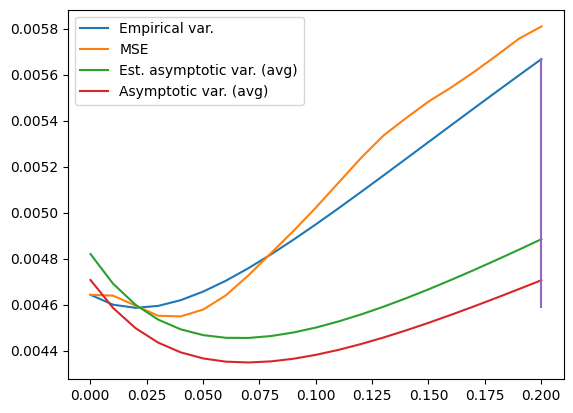

(0.0001, 0.2001)

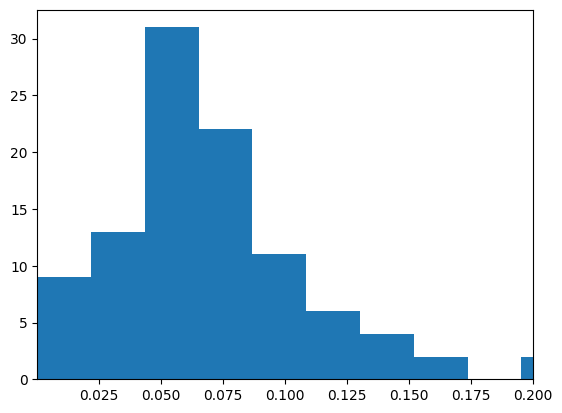

In [304]:
plt.plot(df['gamma'], df['var_emp'], label='Empirical var.')#(df, x='gamma', y='var_emp')
plt.plot(df['gamma'], df.loc[0,'var_emp']*df['MSE']/df.loc[0,'MSE'], label='MSE')
plt.plot(df['gamma'], df['est_var_as'], label='Est. asymptotic var. (avg)')
plt.plot(df['gamma'], df['var_rbf'],label='Asymptotic var. (avg)')
plt.vlines(x=0.2, ymin=np.min(df['var_emp']), ymax=np.max(df['var_emp']), color='C4')
plt.legend()
plt.show()
plt.hist(df_results['gamma_numerical'])
plt.xlim(gamma_seq[0], gamma_seq[-1])

In [283]:
df_results_emp.loc[0,:]

pi_ipr       0.681679
pi_nrm       0.676773
var_n        0.004499
var          0.192793
seed         0.000000
gamma        0.000100
gamma_rbf    0.201725
Name: 0, dtype: float64

In [287]:
df_results_emp.loc[21,:]

pi_ipr       0.830739
pi_nrm       0.821929
var_n        0.004684
var          0.200733
seed         1.000000
gamma        0.000100
gamma_rbf    0.201725
Name: 21, dtype: float64

/tmp/ipykernel_921517/665563083.py:1: FutureWarning: The provided callable <function var at 0x7ecaa0125620> is currently using DataFrameGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  df1 = df_results_emp[['gamma', 'MSE']].groupby('gamma').aggregate(np.var).reset_index()


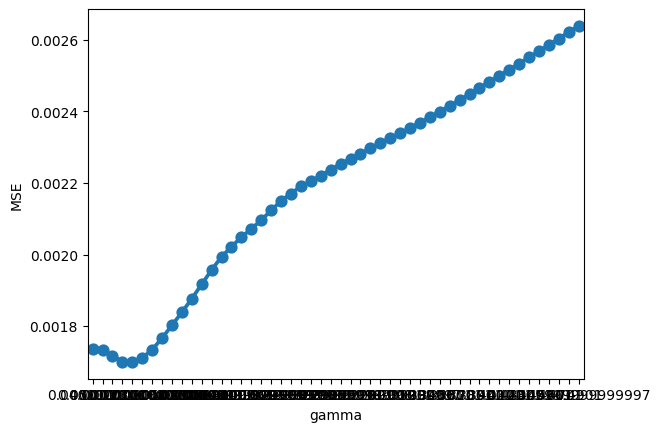

In [251]:
df1 = df_results_emp[['gamma', 'MSE']].groupby('gamma').aggregate(np.var).reset_index()
sns.pointplot(df1, x='gamma', y='MSE')
plt.show()

In [252]:
df

,gamma,MSE,RMSE_div20,var_emp
0,0.0001,0.001735,0.002082,0.004642
1,0.0101,0.001733,0.002082,0.004599
2,0.0201,0.001717,0.002072,0.004586
3,0.0301,0.001701,0.002062,0.004594
4,0.0401,0.001700,0.002061,0.004619
5,0.0501,0.001711,0.002068,0.004657
6,0.0601,0.001734,0.002082,0.004704
7,0.0701,0.001766,0.002101,0.004758
8,0.0801,0.001802,0.002123,0.004818
9,0.0901,0.001838,0.002144,0.004882
